In [46]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
#import capsnet
from SegCaps import capsule_layers
import dataset
import model_functions as mf
import audio_functions as af

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'


In [75]:
#  Set other variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=2
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 10
mag_phase = True

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
pipeline = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipeline.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

In [63]:
class SegCaps_CapsNetBasic(object):
    
    def __init__(self, mixed_mag, mixed_phase, voice_mag, is_training, reuse=True, name='SegCaps_CapsNetBasic'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.mixed_phase = mixed_phase
            self.voice_mag = voice_mag
            
            with tf.variable_scope('Convolution'):
                conv1 = mf.conv(mixed_mag, filters=128, kernel_size=5, stride=(1, 1))
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = conv1.get_shape()
                conv1 = layers.Reshape((H.value, W.value, 1, C.value))(conv1)
                #conv1 = tf.expand_dims(conv1, 2)
                self.conv1 = conv1
            
            with tf.variable_scope('Primary_Caps'):
                primary_caps = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=16, strides=1, padding='same',
                                                               routings=1, name='primarycaps')(conv1)
                self.primary_caps = primary_caps
                
            with tf.variable_scope('Seg_Caps'):
                seg_caps = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(primary_caps)
                self.seg_caps = seg_caps
            
            with tf.variable_scope('Reconstruction'):
                reconstruction = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(seg_caps)
                reconstruction = tf.squeeze(reconstruction,-1)
                self.reconstruction = reconstruction
            
            self.cost = mf.l1_loss(self.reconstruction, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [64]:
class UNetModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            self.voice_mask_unet = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')

            self.voice_mask = self.voice_mask_unet.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.pw_cost = mf.pw_l1_loss(self.gen_voice, voice_mag)
            self.cost = tf.reduce_mean(self.pw_cost)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.pw_cost)


class UNet(object):

    def __init__(self, input_tensor, variant, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):
            self.variant = variant

            if self.variant == 'unet':
                self.encoder = UNetEncoder(input_tensor, is_training, reuse)
                self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)
            elif self.variant == 'capsunet':
                self.encoder = CapsUNetEncoder(input_tensor, is_training, reuse)
                self.decoder = CapsUNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = mf.tanh(self.decoder.output) / 2 + .5

class UNetEncoder(object):
    """
    The down-convolution side of a convoltional U-Net model.
    """

    def __init__(self, input_tensor, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('encoder'):
            with tf.variable_scope('layer-1'):
                net = mf.conv(net, filters=16, kernel_size=5, stride=(2, 2))
                self.l1 = net

            with tf.variable_scope('layer-2'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l2 = net

            with tf.variable_scope('layer-3'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l3 = net

            with tf.variable_scope('layer-4'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l4 = net

            with tf.variable_scope('layer-5'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l5 = net

            with tf.variable_scope('layer-6'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=512, kernel_size=5, stride=(2, 2))

            self.output = net


class UNetDecoder(object):
    """
    The up-convolution side of a convolutional U-Net model
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor

        with tf.variable_scope('decoder'):
            with tf.variable_scope('layer-1'):
                net = mf.relu(net)
                net = mf.deconv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-2'):
                net = mf.relu(mf.concat(net, encoder.l5))
                net = mf.deconv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-3'):
                net = mf.relu(mf.concat(net, encoder.l4))
                net = mf.deconv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-4'):
                net = mf.relu(mf.concat(net, encoder.l3))
                net = mf.deconv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-5'):
                net = mf.relu(mf.concat(net, encoder.l2))
                net = mf.deconv(net, filters=16, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-6'):
                net = mf.relu(mf.concat(net, encoder.l1))
                net = mf.deconv(net, filters=1, kernel_size=5, stride=(2, 2))

            self.output = net


class CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        with tf.variable_scope('Encoder'):
            with tf.variable_scope('Convolution'):
                # Layer 1: Just a conventional Conv2D layer
                net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)

                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = net.get_shape()
                net = layers.Reshape((H.value, W.value, 1, C.value))(net)
                self.conv1 = net

            with tf.variable_scope('Primary_Caps'):
                # Layer 1: Primary Capsule: Conv cap with routing 1
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                                    routings=1, name='primarycaps')(net)
                self.primary_caps = net

            with tf.variable_scope('Conv_caps_2'):
                # Layer 2: Convolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='conv_cap_2_1')(net)
                self.conv_cap_2_1 = net

                # Layer 2: Convolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                                      routings=3, name='conv_cap_2_2')(net)
                self.conv_cap_2_2 = net

            with tf.variable_scope('Conv_caps_3'):
                # Layer 3: Convolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_3_1')(net)
                self.conv_cap_3_1 = net

                # Layer 3: Convolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                                    routings=3, name='conv_cap_3_2')(net)
                self.conv_cap_3_2 = net

            with tf.variable_scope('Conv_caps_4'):
                # Layer 4: Convolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_4_1')(net)

            self.output = net


class CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('Decoder'):
            with tf.variable_scope('UpCaps_1'):
                    # Layer 1 Up: Deconvolutional Capsule
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_1_1')(net)
                self.upcap_1_1 = net

                # Skip connection
                net = layers.Concatenate(axis=-2, name='up_1')([net, encoder.conv_cap_3_1])

                # Layer 1 Up: Deconvolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_1_2')(net)
                self.upcap_1_2 = net

            with tf.variable_scope('UpCaps_2'):
                # Layer 2 Up: Deconvolutional Capsule
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_2_1')(net)
                self.upcap_2_1 = net

                # Skip connection
                net = layers.Concatenate(axis=-2, name='up_2')([net, encoder.conv_cap_2_1])

                # Layer 2 Up: Deconvolutional Capsule
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_2_2')(net)
                self.upcap_2_2 = net

            with tf.variable_scope('UpCaps_3'):
                # Layer 3 Up: Deconvolutional Capsule
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_3_1')(net)
                self.upcap_3_1 = net

                # Skip connection
                net = layers.Concatenate(axis=-2, name='up_3')([net, encoder.conv1])
            with tf.variable_scope('Reconstruction'):
                # Layer 4: Convolutional Capsule: 1x1
                net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='seg_caps')(net)
                
                _, H, W, C, D = net.get_shape()
                
                net = layers.Reshape((H.value, W.value, D.value))(net)

                net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_1')(net)

                net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_2')(net)

                net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='sigmoid', name='out_recon')(net)

            self.output = net

In [76]:
#tf.reset_default_graph()
#model = SegCaps_CapsNetBasic(mixed_mag, mixed_phase, voice_mag, is_training=False)
model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'capsunet', is_training=True, name='R3_CapsNet')
#model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training=True, name='R3_CapsNet')

### Basic Caps Net - Layer Dimensions

In [53]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.primary_caps.get_shape().as_list(),
      '\nSeg Caps: ',model.seg_caps.get_shape().as_list(),
      '\nRecontruction: ',model.reconstruction.get_shape().as_list())

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 1, 128] 
Primary Caps:  [None, 256, 512, 8, 16] 
Seg Caps:  [None, 256, 512, 1, 16] 
Recontruction:  [None, 256, 512, 1]


### R3 Caps Net - Layer Dimensions

In [66]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.voice_mask_unet.encoder.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.voice_mask_unet.encoder.primary_caps.get_shape().as_list(),
      '\nConv Caps 2.1: ',model.voice_mask_unet.encoder.conv_cap_2_1.get_shape().as_list(),
      '\nConv Caps 2.2: ',model.voice_mask_unet.encoder.conv_cap_2_2.get_shape().as_list(),
      '\nConv Caps 3.1: ',model.voice_mask_unet.encoder.conv_cap_3_1.get_shape().as_list(),
      '\nConv Caps 3.2: ',model.voice_mask_unet.encoder.conv_cap_3_2.get_shape().as_list(),
      '\nConv Caps 4 (output): ',model.voice_mask_unet.encoder.output.get_shape().as_list(),
      
      '\n\nUp Caps 1.1: ',model.voice_mask_unet.decoder.upcap_1_1.get_shape().as_list(),
      '\nUp Caps 1.2: ',model.voice_mask_unet.decoder.upcap_1_2.get_shape().as_list(),
      '\nUp Caps 2.1: ',model.voice_mask_unet.decoder.upcap_2_1.get_shape().as_list(),
      '\nUp Caps 2.2: ',model.voice_mask_unet.decoder.upcap_2_2.get_shape().as_list(),
      '\nUp Caps 3.1: ',model.voice_mask_unet.decoder.upcap_3_1.get_shape().as_list(),
      '\nUp Caps 4 (output): ',model.voice_mask_unet.decoder.output.get_shape().as_list()
      )

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 1, 16] 
Primary Caps:  [None, 128, 256, 2, 16] 
Conv Caps 2.1:  [None, 128, 256, 4, 16] 
Conv Caps 2.2:  [None, 64, 128, 4, 32] 
Conv Caps 3.1:  [None, 64, 128, 8, 32] 
Conv Caps 3.2:  [None, 32, 64, 8, 64] 
Conv Caps 4 (output):  [None, 32, 64, 8, 32] 

Up Caps 1.1:  [None, 64, 128, 8, 32] 
Up Caps 1.2:  [None, 64, 128, 4, 32] 
Up Caps 2.1:  [None, 128, 256, 4, 16] 
Up Caps 2.2:  [None, 128, 256, 4, 16] 
Up Caps 3.1:  [None, 256, 512, 2, 16] 
Up Caps 4 (output):  [None, 256, 512, 1]


In [77]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(pipeline.initializer)

In [78]:
mix, phase, voice, mask = sess.run([model.mixed_mag, model.mixed_phase, model.voice_mag, model.voice_mask])

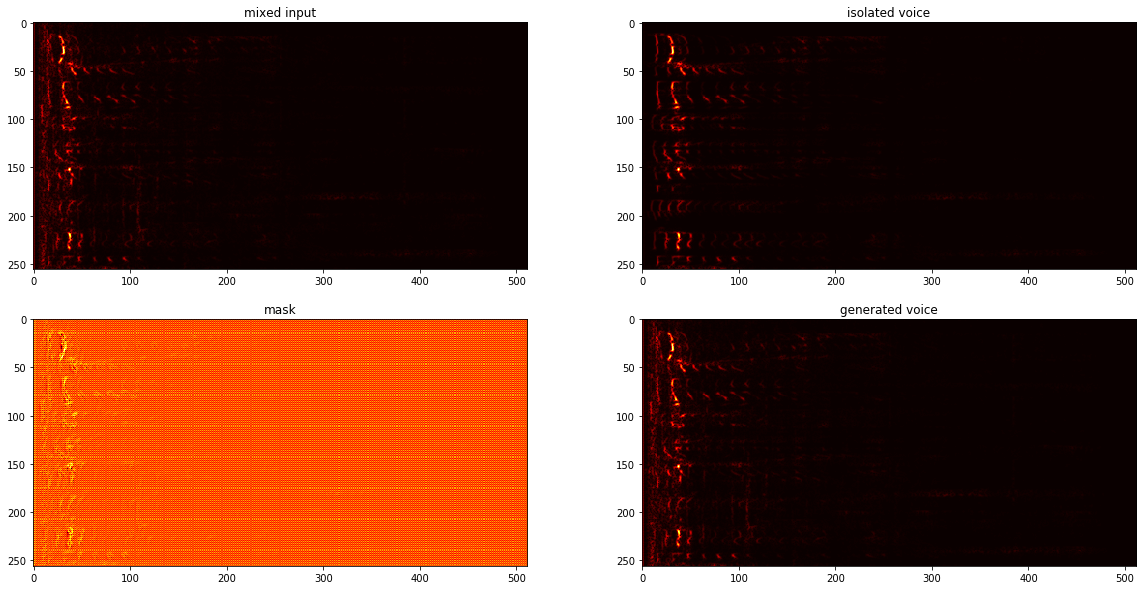

In [79]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [88]:
for i in range(4000):
    try:
        _, mix, phase, voice, mask, cost = sess.run([model.train_op, model.mixed_mag, model.mixed_phase, 
                                                     model.voice_mag, model.voice_mask, model.cost])
        print(cost)
    except tf.errors.OutOfRangeError:
        print('Epoch complete')
        sess.run(pipeline.initializer)
    

0.0041896035
0.003509025
0.0034813066
0.0016714574
0.002313973
0.0020908813
0.0014315683
0.002266915
0.0019599139
0.00213326
0.0020314627
0.0076223114
0.0025306134
0.0029483817
Epoch complete
0.0033966652
0.0014414869
0.004151838
0.0029262572
0.0029510213
0.00206023
0.0073084864
0.0016091588
0.0034176176
0.0026462052
0.003775426
0.0038698749
0.0034718337
0.003461612
0.0022338426
0.0021083222
0.0022946724
0.0022970208
0.002156109
0.002790249
0.0017782818
0.001962984
0.002231977
0.0036723225
0.0025222604
Epoch complete
0.0037993402
0.003878238
0.00343553
0.0029200201
0.003313166
0.0021294518
0.0027924941
0.0028975527
0.003645592
0.0017517547
0.0022369267
0.0013680661
0.002345393
0.0022300067
0.0015382648
0.0077052033
0.004116065
0.0021815617
0.0022699146
0.0026157296
0.0025408776
0.0034895714
0.001980912
0.0021139882
0.0034532323
Epoch complete
0.0041284803
0.001640761
0.0037467654
0.0021127053
0.0017953741
0.0072020134
0.003468289
0.0033547678
0.0039027866
0.0028277892
0.0022955518
0.00

0.0015310296
0.0013573888
0.002899446
0.0042473106
0.0019617989
0.007453711
0.003727791
0.0034769946
0.00267511
0.003923098
0.0022793794
0.0023452044
0.0038339826
0.0027900005
0.0021198047
0.0021262823
0.001928067
0.00340773
0.0020299086
0.0035481364
0.0024915375
0.0022218307
0.002922384
Epoch complete
0.0034020778
0.002116834
0.0032497826
0.003853756
0.003608401
0.0042084586
0.0073811254
0.0028095408
0.0021228609
0.0016114874
0.0026177154
0.0029656969
0.0034245993
0.0019481586
0.0017602646
0.0024877815
0.0021423642
0.002228342
0.0020376963
0.002894063
0.002199477
0.0035762088
0.0013592844
0.0022619525
0.0037318994
Epoch complete
0.0037229434
0.0033004766
0.002130432
0.0017300036
0.0015118602
0.0034178537
0.002771947
0.0035329713
0.0071260794
0.0026284019
0.0015276957
0.002473833
0.0034450078
0.0020035305
0.004081784
0.003755106
0.00205102
0.0029077027
0.0029019827
0.0021089616
0.0022823769
0.00196117
0.0021961676
0.0024950586
0.0038659358
Epoch complete
0.0021053362
0.0037392243
0.003

0.0026025807
0.0021747262
0.0041307816
0.0016919855
0.0018867399
0.0021758457
0.0020076851
Epoch complete
0.0037429282
0.0020979145
0.0013160387
0.0038018355
0.0019068611
0.0033853208
0.0028577528
0.0027619845
0.0031931433
0.0022831913
0.004144677
0.0035877419
0.0016849611
0.0014981905
0.0025932216
0.0024381538
0.0034988318
0.006906005
0.0021091714
0.0024107324
0.0029422352
0.0021472895
0.0033784383
0.0018913276
0.0021798168
Epoch complete
0.0016830161
0.0037882072
0.00338232
0.0013200196
0.0027549434
0.0040986743
0.0037152378
0.0032482734
0.0036005643
0.0035168948
0.006929362
0.0022820637
0.00300445
0.0029277315
0.002585878
0.0015219158
0.0021109486
0.0021545507
0.0034840815
0.0024488084
0.0020137136
0.0022488292
0.002119701
0.0018866383
0.001913956
Epoch complete
0.0016726812
0.0014731309
0.0031699575
0.0012883204
0.0038086204
0.0034089484
0.0018855331
0.0020718009
0.0041688024
0.003470803
0.0025813505
0.0037883674
0.0022247343
0.0019173898
0.0036150995
0.0069716987
0.0028000656
0.00

0.0016307152
0.00355324
0.0014445685
0.0028162627
0.0035038732
0.006669621
0.0026413715
0.0034529187
0.0020148167
0.0023004788
0.0022035395
0.004069469
0.0024312092
0.0022465887
0.0028707709
0.0020490023
0.0018760595
0.002045927
0.0019670136
Epoch complete
0.0016259854
0.004181955
0.0012789353
0.0035658553
0.0033488306
0.0014505028
0.0034014233
0.0027403934
0.0028632572
0.0066026556
0.001940704
0.0038045326
0.00220357
0.002422079
0.0021462035
0.0037206847
0.0025955127
0.0019784572
0.0020635966
0.0034626094
0.0032085439
0.002053345
0.0028316944
0.0018464106
0.0022636326
Epoch complete
0.004105921
0.003594405
0.0033358186
0.0028570204
0.0016409513
0.003752526
0.0012793137
0.0028479116
0.006721173
0.0032717348
0.0023480963
0.0028777316
0.0022990552
0.003725381
0.002082687
0.0031781886
0.0020482123
0.002441965
0.002616256
0.0018669163
0.0034822575
0.002174615
0.001985342
0.0018643776
0.0014748145
Epoch complete
0.0020477753
0.0014419353
0.003146681
0.0035418384
0.0017972254
0.0028938265
0.

0.0022576777
0.0019867206
0.0021398696
Epoch complete
0.0012450637
0.0033483244
0.0031507732
0.0018063206
0.002850674
0.0037567362
0.0015957666
0.0064463234
0.0028636917
0.0036609585
0.0034219245
0.00221027
0.0025286071
0.0018533608
0.0024168347
0.0027065827
0.0036839577
0.004023961
0.0020482556
0.003274536
0.002057621
0.002170126
0.001445281
0.00210112
0.0019545667
Epoch complete
0.0017912029
0.0036908584
0.0033343944
0.0012400572
0.0028002944
0.0028317114
0.0014144069
0.0025792196
0.0020233365
0.002209686
0.00270684
0.0040297033
0.0021525782
0.002412551
0.0034190482
0.00635436
0.0020362409
0.0032311375
0.0038471743
0.0018724746
0.0035829402
0.0015985767
0.0031456826
0.0020246264
0.0020849826
Epoch complete
0.0041208672
0.0012435007
0.0035723795
0.0014362956
0.0033144904
0.0064781904
0.0028579333
0.0025790944
0.0037538623
0.0027045999
0.001599694
0.0035212412
0.0033190683
0.0022048876
0.0018897431
0.0036641816
0.0022099693
0.002407223
0.0021224748
0.002029501
0.001807853
0.0019450822


0.0035456885
0.0032396563
0.0028210222
0.00124534
0.002027059
0.006275088
0.0018507328
0.0014338843
0.0021498029
0.002070959
0.0020128572
0.001947745
0.0035035703
0.0024006953
0.0026781028
Epoch complete
0.0020262273
0.0017970994
0.0031347754
0.0012154601
0.002823445
0.0037348918
0.0039977897
0.0062192446
0.0033516907
0.0031833975
0.0026999465
0.0021152908
0.0036865491
0.0024012183
0.002799729
0.0020250874
0.0035287677
0.002539833
0.0018161343
0.001932473
0.0015833185
0.0014156965
0.0022001169
0.0034204666
0.002140828
Epoch complete
0.0015802318
0.001415277
0.0012148714
0.0037183634
0.0031394153
0.0032780431
0.0020161862
0.006283577
0.0027207807
0.0027968213
0.0020731867
0.003522117
0.0028160228
0.0018190967
0.0036330528
0.004000853
0.003199766
0.0021733707
0.0033851066
0.0020437955
0.0018458185
0.002397539
0.002202729
0.0025102922
0.0019345686
Epoch complete
0.0031554513
0.0036813798
0.0015769899
0.0012221793
0.0028016963
0.006295574
0.0014362797
0.002540312
0.0027887146
0.002203437
0

0.0031145746
0.001379976
0.0019973556
0.0034912582
0.0036583175
0.006245251
0.0032071075
0.0016239755
0.002850119
0.0036563894
0.0034060758
0.0017947629
0.003242717
0.002782551
0.0023854377
0.002173713
0.0018101002
0.0021014553
0.0019135703
0.0020472582
0.00265344
0.001207314
0.0039816815
0.0024424335
0.0020350888
Epoch complete
0.0039217947
0.0012277046
0.0027485322
0.0031230473
0.00278077
0.0032517184
0.003519023
0.0036435802
0.0035667634
0.0033739638
0.0020291775
0.0026504875
0.0020647116
0.0063029
0.0032163654
0.0016335656
0.001474409
0.0020427192
0.002123096
0.0025523175
0.0017704475
0.0019164316
0.0023935856
0.0021725986
0.0018124991
Epoch complete
0.0012160933
0.003265497
0.002008617
0.0013857456
0.0015684915
0.0027869672
0.0036629732
0.0031368977
0.0026478767
0.002739791
0.0021714172
0.0033901786
0.0035598099
0.002126948
0.0020642001
0.001996141
0.0039948644
0.0019203275
0.002395733
0.0035421494
0.0017812876
0.0063969907
0.0018788665
0.0025790078
0.0032005948
Epoch complete
0.0

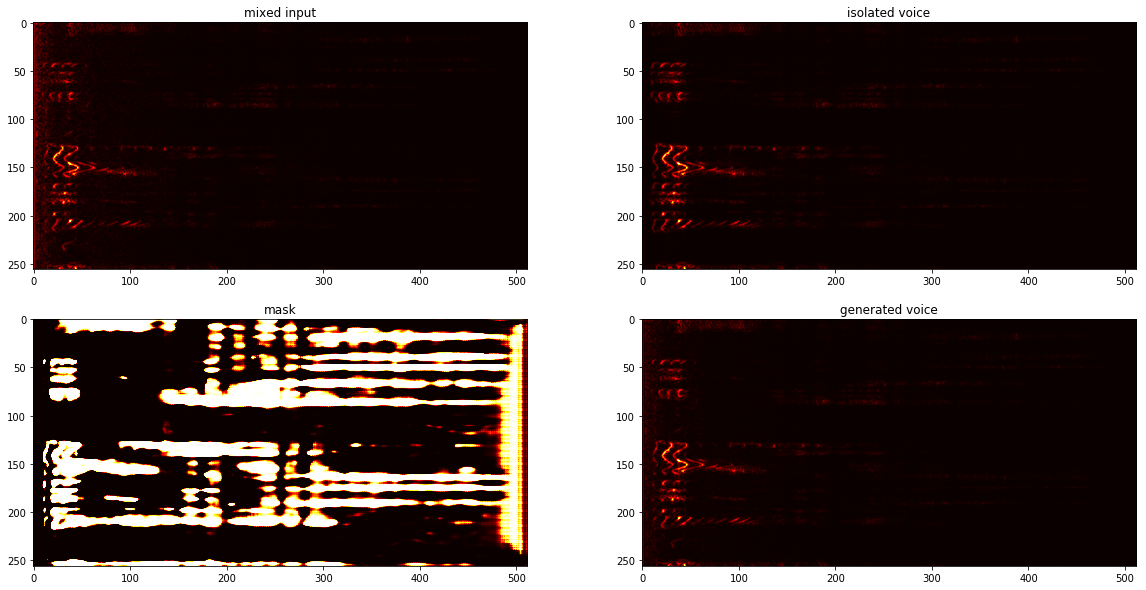

In [89]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [90]:
mix_wave = []
voice_wave = []
gen_wave = []

for i in range(mix.shape[0]):
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    gen_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :] * mask[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))

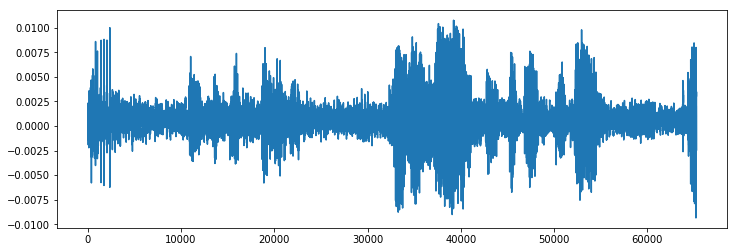

In [94]:
i=0
#  The original mixture
plt.figure(figsize=(12,4))
x = range(len(mix_wave[i]))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i], rate=sample_rate)

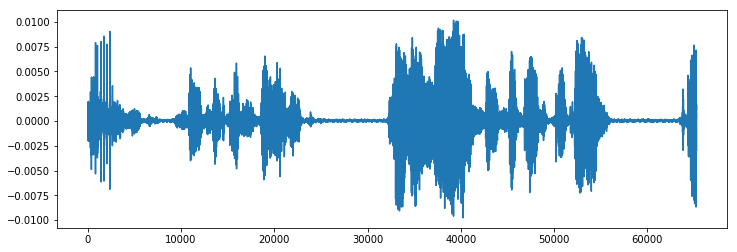

In [97]:
#  The isolated voice
plt.figure(figsize=(12,4))
x = range(len(voice_wave[i]))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i], rate=sample_rate)

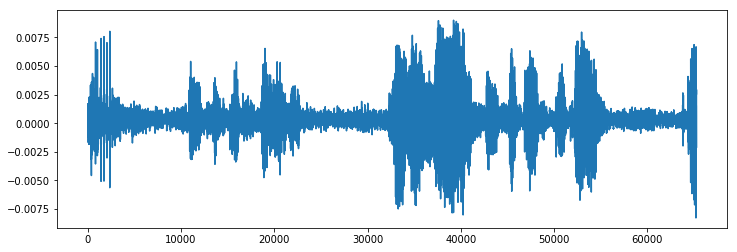

In [98]:
#  The model output
plt.figure(figsize=(12,4))
x = range(len(gen_wave[i]))
plt.plot(x,gen_wave[i])
ipd.Audio(gen_wave[i], rate=sample_rate)

In [ ]:
plt.imshow(mask[4,:,:,0])
plt.show()

In [ ]:
mix[0,:,:,0] * mask[0,:,:,0]

In [ ]:
voice[0,:,:,0]

In [41]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
m_mag, v_mag = sess.run([mixed_mag, voice_mag])

In [44]:
mask = v_mag > 2e-02
masked_mix = m_mag.copy()
masked_mix[mask == 0] = 0

Text(0.5, 1.0, 'Masked Mixture Magnitude Spectrogram')

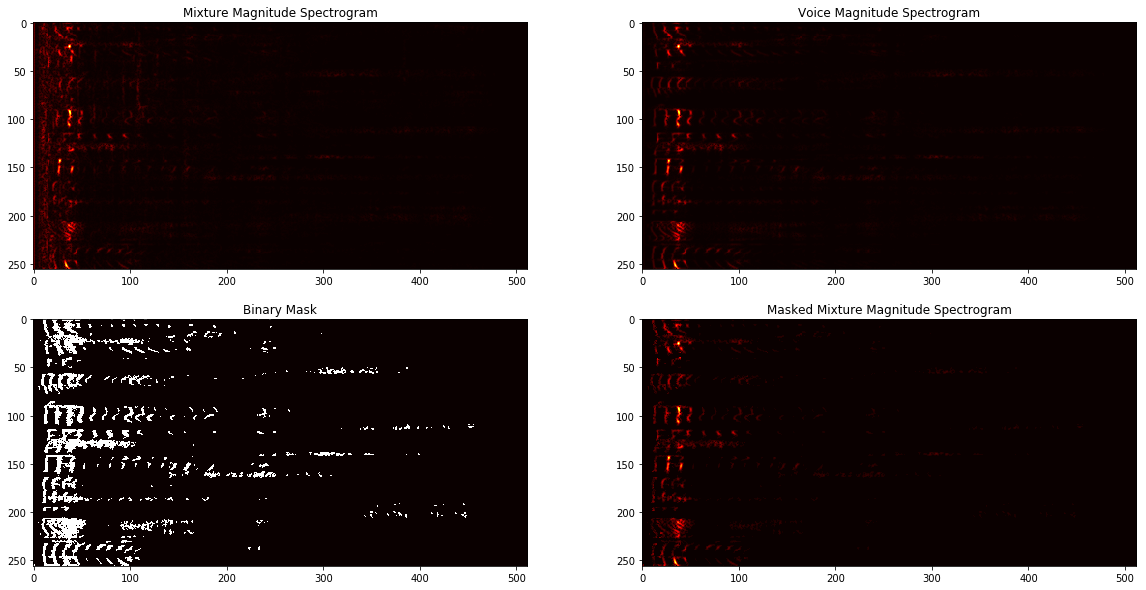

In [45]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(m_mag[0,:,:,0])
ax[0,0].set_title('Mixture Magnitude Spectrogram')
ax[0,1].imshow(v_mag[0,:,:,0])
ax[0,1].set_title('Voice Magnitude Spectrogram')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('Binary Mask')
ax[1,1].imshow(masked_mix[0,:,:,0])
ax[1,1].set_title('Masked Mixture Magnitude Spectrogram')